In [81]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
import time
import spacy
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import utils

In [2]:
nlp = spacy.load("en_core_web_md")

In [3]:
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

In [4]:
train.head(2)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL


In [5]:
test.head(2)

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."


In [6]:
print("Number of labelled training examples: {}".format(train.shape[0]))

Number of labelled training examples: 19579


Distribution of training data for the three authors


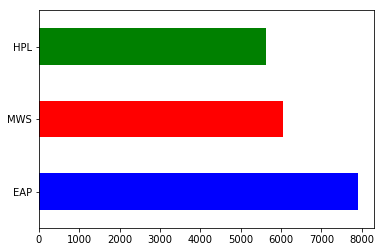

In [7]:
print("Distribution of training data for the three authors")
train['author'].value_counts().plot(kind="barh", color='brg')

In [8]:
print("Number of unlabelled test examples: {}".format(test.shape[0]))

Number of unlabelled test examples: 8392


In [9]:
# simple split for screening model performance
X_train, X_test, y_train, y_test = train_test_split(train, train.author, test_size=0.20, random_state=42)

In [10]:
# n-fold stratified CV for robust model performance
X = train
y = train.author

In [11]:
le = preprocessing.LabelEncoder()
le.fit(y)

LabelEncoder()

In [12]:
le.classes_

array(['EAP', 'HPL', 'MWS'], dtype=object)

In [13]:
# sanity check for label ordering
# 0: EAP, 1: HPL, 2: MWS

In [14]:
y[:5]

0    EAP
1    HPL
2    EAP
3    MWS
4    HPL
Name: author, dtype: object

In [15]:
le.transform(y)[:5]

array([0, 1, 0, 2, 1])

## Author-specific Named Entities

In [16]:
ner_EAP = pd.read_csv('data/ner_EAP.csv', header=None)
ner_EAP = ner_EAP[0].tolist()
ner_HPL = pd.read_csv('data/ner_HPL.csv', header=None)
ner_HPL = ner_HPL[0].tolist()
ner_MWS = pd.read_csv('data/ner_MWS.csv', header=None)
ner_MWS = ner_MWS[0].tolist()

In [17]:
ner_EAP[:5]

['Epicurus', "Von Kempelen's", 'Underduk', 'Ellison', 'Mein Gott']

In [18]:
def kfold_CV(clf, X, y, folds, transform=True):
    """ Run a stratified k-fold Cross Validation on the training set and print the results.
        
        Args:
            clf (Pipeline): sklearn Pipeline
            X    (pandas df): data points, here: novel snippets
            y    (pandas df): class labels, here: authors
            folds      (int): number of folds
            transform (bool): if True, use .fit_transform(); if False, use .fit()
    """

    kf = StratifiedKFold(n_splits=folds, shuffle=True)
    
    precision, recall, f1 = [], [], []

    fold_cntr = 1
    for train_index, test_index in kf.split(X,y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if transform == True:
            clf.fit_transform(X_train, y_train)
        else:
            clf.fit(X_train, y_train)
        
        predicted = text_clf.predict(X_test)
        prec_, rec_, f1_ = precision_recall_fscore_support(y_test, predicted, average='macro')[:3]
        
        precision.append(prec_)
        recall.append(rec_)
        f1.append(f1_)
        
        print("FOLD: {} Precision: {}, Recall: {}, F1: {}".format(fold_cntr, round(prec_,3), round(rec_,3), round(f1_,3)))
        fold_cntr += 1
        
    print("\nAverage results of {}-fold stratified CV\n".format(folds))
    print("Precision: {}, Standard deviation: {}".format(np.mean(precision), np.std(precision)))
    print("Recall:    {}, Standard deviation: {}".format(np.mean(recall), np.std(recall)))
    print("Macro f1:  {}, Standard deviation: {}".format(np.mean(f1), np.std(f1)))

In [70]:
class DataFrameColumnExtracter(BaseEstimator, TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

In [72]:
class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):

        return [{'length':len(nlp(text)),
                 'num_sentences': len([sent for sent in nlp(text).sents]),
                 'num_punctuations': len([token for token in nlp(text) if token.pos_ == "PUNCT"]),
                 'num_descript_words': len([token for token in nlp(text) if token.pos_ == "ADJ" or token.pos_ == "ADV"])
                } for text in posts]

In [73]:
class NER_extractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        """The workhorse of this feature extractor"""
        ner_list = []
        for text in posts:
            doc = nlp(text)
            eap_ners = 0
            hpl_ners = 0
            mws_ners = 0
            if doc.ents:
                for ent in doc.ents:
                    if ent.text in ner_EAP:
                        eap_ners += 1
                    elif ent.text in ner_HPL:
                        hpl_ners += 1
                    elif ent.text in ner_MWS:
                        mws_ners += 1
                    
            # print({'eap_ners':eap_ners, 'hpl_ners':hpl_ners, 'mws_ner':mws_ners})
            ner_list.append({'eap_ners':eap_ners, 'hpl_ners':hpl_ners, 'mws_ner':mws_ners})
        return ner_list

In [74]:
# Use FeatureUnion to combine the features
featureunionvect = FeatureUnion(
    transformer_list=[

        # Pipeline for pulling features from the text snippet
        ('text_snippet', Pipeline([
            ('selector', DataFrameColumnExtracter('text')),
            ('vec', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
        ])),

        # Pipeline for pulling ad hoc features text snippet
        ('text_stats', Pipeline([
            ('selector', DataFrameColumnExtracter('text')),
            ('stats', TextStats()),  # returns a list of dicts
            ('stats_vec', DictVectorizer()),  # list of dicts -> feature matrix
        ])),

        # Pipeline for pulling NER features text snippet
        ('text_ner', Pipeline([
            ('selector', DataFrameColumnExtracter('text')),
            ('ner', NER_extractor()),  # returns a list of dicts
            ('ner_vect', DictVectorizer()),  # list of dicts -> feature matrix
        ])),

    ],

    # weight components in FeatureUnion
    transformer_weights=None,
)

In [75]:
classifier = LogisticRegression()

In [76]:
pipeline = Pipeline([('vect', featureunionvect), ('classifier', classifier)])

In [77]:
X_train_sample = X_train#.head(10)
y_train_sample = y_train#.head(10)

In [78]:
pipeline.fit(X_train_sample, y_train_sample)

Pipeline(steps=[('vect', FeatureUnion(n_jobs=1,
       transformer_list=[('text_snippet', Pipeline(steps=[('selector', DataFrameColumnExtracter(column='text')), ('vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content'...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [79]:
predicted = pipeline.predict(X_test)

In [80]:
print(classification_report(predicted, y_test))

             precision    recall  f1-score   support

        EAP       0.88      0.79      0.83      1754
        HPL       0.78      0.85      0.82       982
        MWS       0.80      0.86      0.83      1180

avg / total       0.83      0.83      0.83      3916



In [67]:
parameters = {
    'vect__text_snippet__vec__max_df': (0.5, 1.0), #0.625, 0.75, 0.875, 
    'vect__text_snippet__vec__max_features': (None, 5000, 10000, 20000),
    'vect__text_snippet__vec__min_df': (1, 5, 10), #, 20, 50), 
    'vect__text_snippet__tfidf__use_idf': (True, False),
    'vect__text_snippet__tfidf__sublinear_tf': (True, False),
    'vect__text_snippet__vec__binary': (True, False),
    'vect__text_snippet__tfidf__norm': ('l1', 'l2'),
    'classifier': (MultinomialNB(), LogisticRegression(), LogisticRegression(), svm.LinearSVC(), svm.SVC())
    }  

In [68]:
grid_search = GridSearchCV(pipeline, parameters, verbose=2, n_jobs=-1)

In [69]:
t0 = time.time()
grid_search.fit(X_train_sample, y_train_sample)
print("done in {0}s".format(time.time() - t0))
print("Best score: {0}".format(grid_search.best_score_))
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(parameters.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

Fitting 3 folds for each of 768 candidates, totalling 2304 fits
[CV] vect__text_snippet__tfidf__use_idf=True, vect__text_snippet__vec__max_df=0.5, vect__text_snippet__tfidf__norm=l1, vect__text_snippet__tfidf__sublinear_tf=True, vect__text_snippet__vec__min_df=1, vect__text_snippet__vec__max_features=None, classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), vect__text_snippet__vec__binary=True 
[CV] vect__text_snippet__tfidf__use_idf=True, vect__text_snippet__vec__max_df=0.5, vect__text_snippet__tfidf__norm=l1, vect__text_snippet__tfidf__sublinear_tf=True, vect__text_snippet__vec__min_df=1, vect__text_snippet__vec__max_features=None, classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), vect__text_snippet__vec__binary=True 
[CV] vect__text_snippet__tfidf__use_idf=True, vect__text_snippet__vec__max_df=0.5, vect__text_snippet__tfidf__norm=l1, vect__text_snippet__tfidf__sublinear_tf=True, vect__text_snippet__vec__min_df=1, vect__text_snippet__vec__max_f

TypeError: catching classes that do not inherit from BaseException is not allowed